### Medical Cost Personal

의료보험 데이터를 이용해 한 사람이 보험표를 얼마나 낼지 예측하는 회귀 문제

- age : 피보험자의 나이
- sex : 피보험자의 성별
- bmi : 피보험자의 체질량 지수 
- children : 피보험자의 자녀 수
- smoker : 흡연 여부
- region : 피보험자가 거주하는 지역 (Southeast / Southwest / Northeast / Northwest)
- charges : 보험료

#### Data and Library Import

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                  MinMaxScaler, PowerTransformer, QuantileTransformer)
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
%matplotlib inline

warnings.filterwarnings(action = 'ignore')
#catboost 제거함

In [6]:
df = pd.read_csv('./Medical Cost Personal Dataset/insurance.csv', engine='python')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Exploratory Data Analysis 

데이터 분포 또는 상관 관계를 살펴보는 단계
특징을 파악하고, 학습이 더욱 잘 이루어질 수 있도록 변환시킬 변수를 찾기

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
# 데이터의 평균과 표준편차, 최댓값, 최솟값, 사분위수
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Visualization

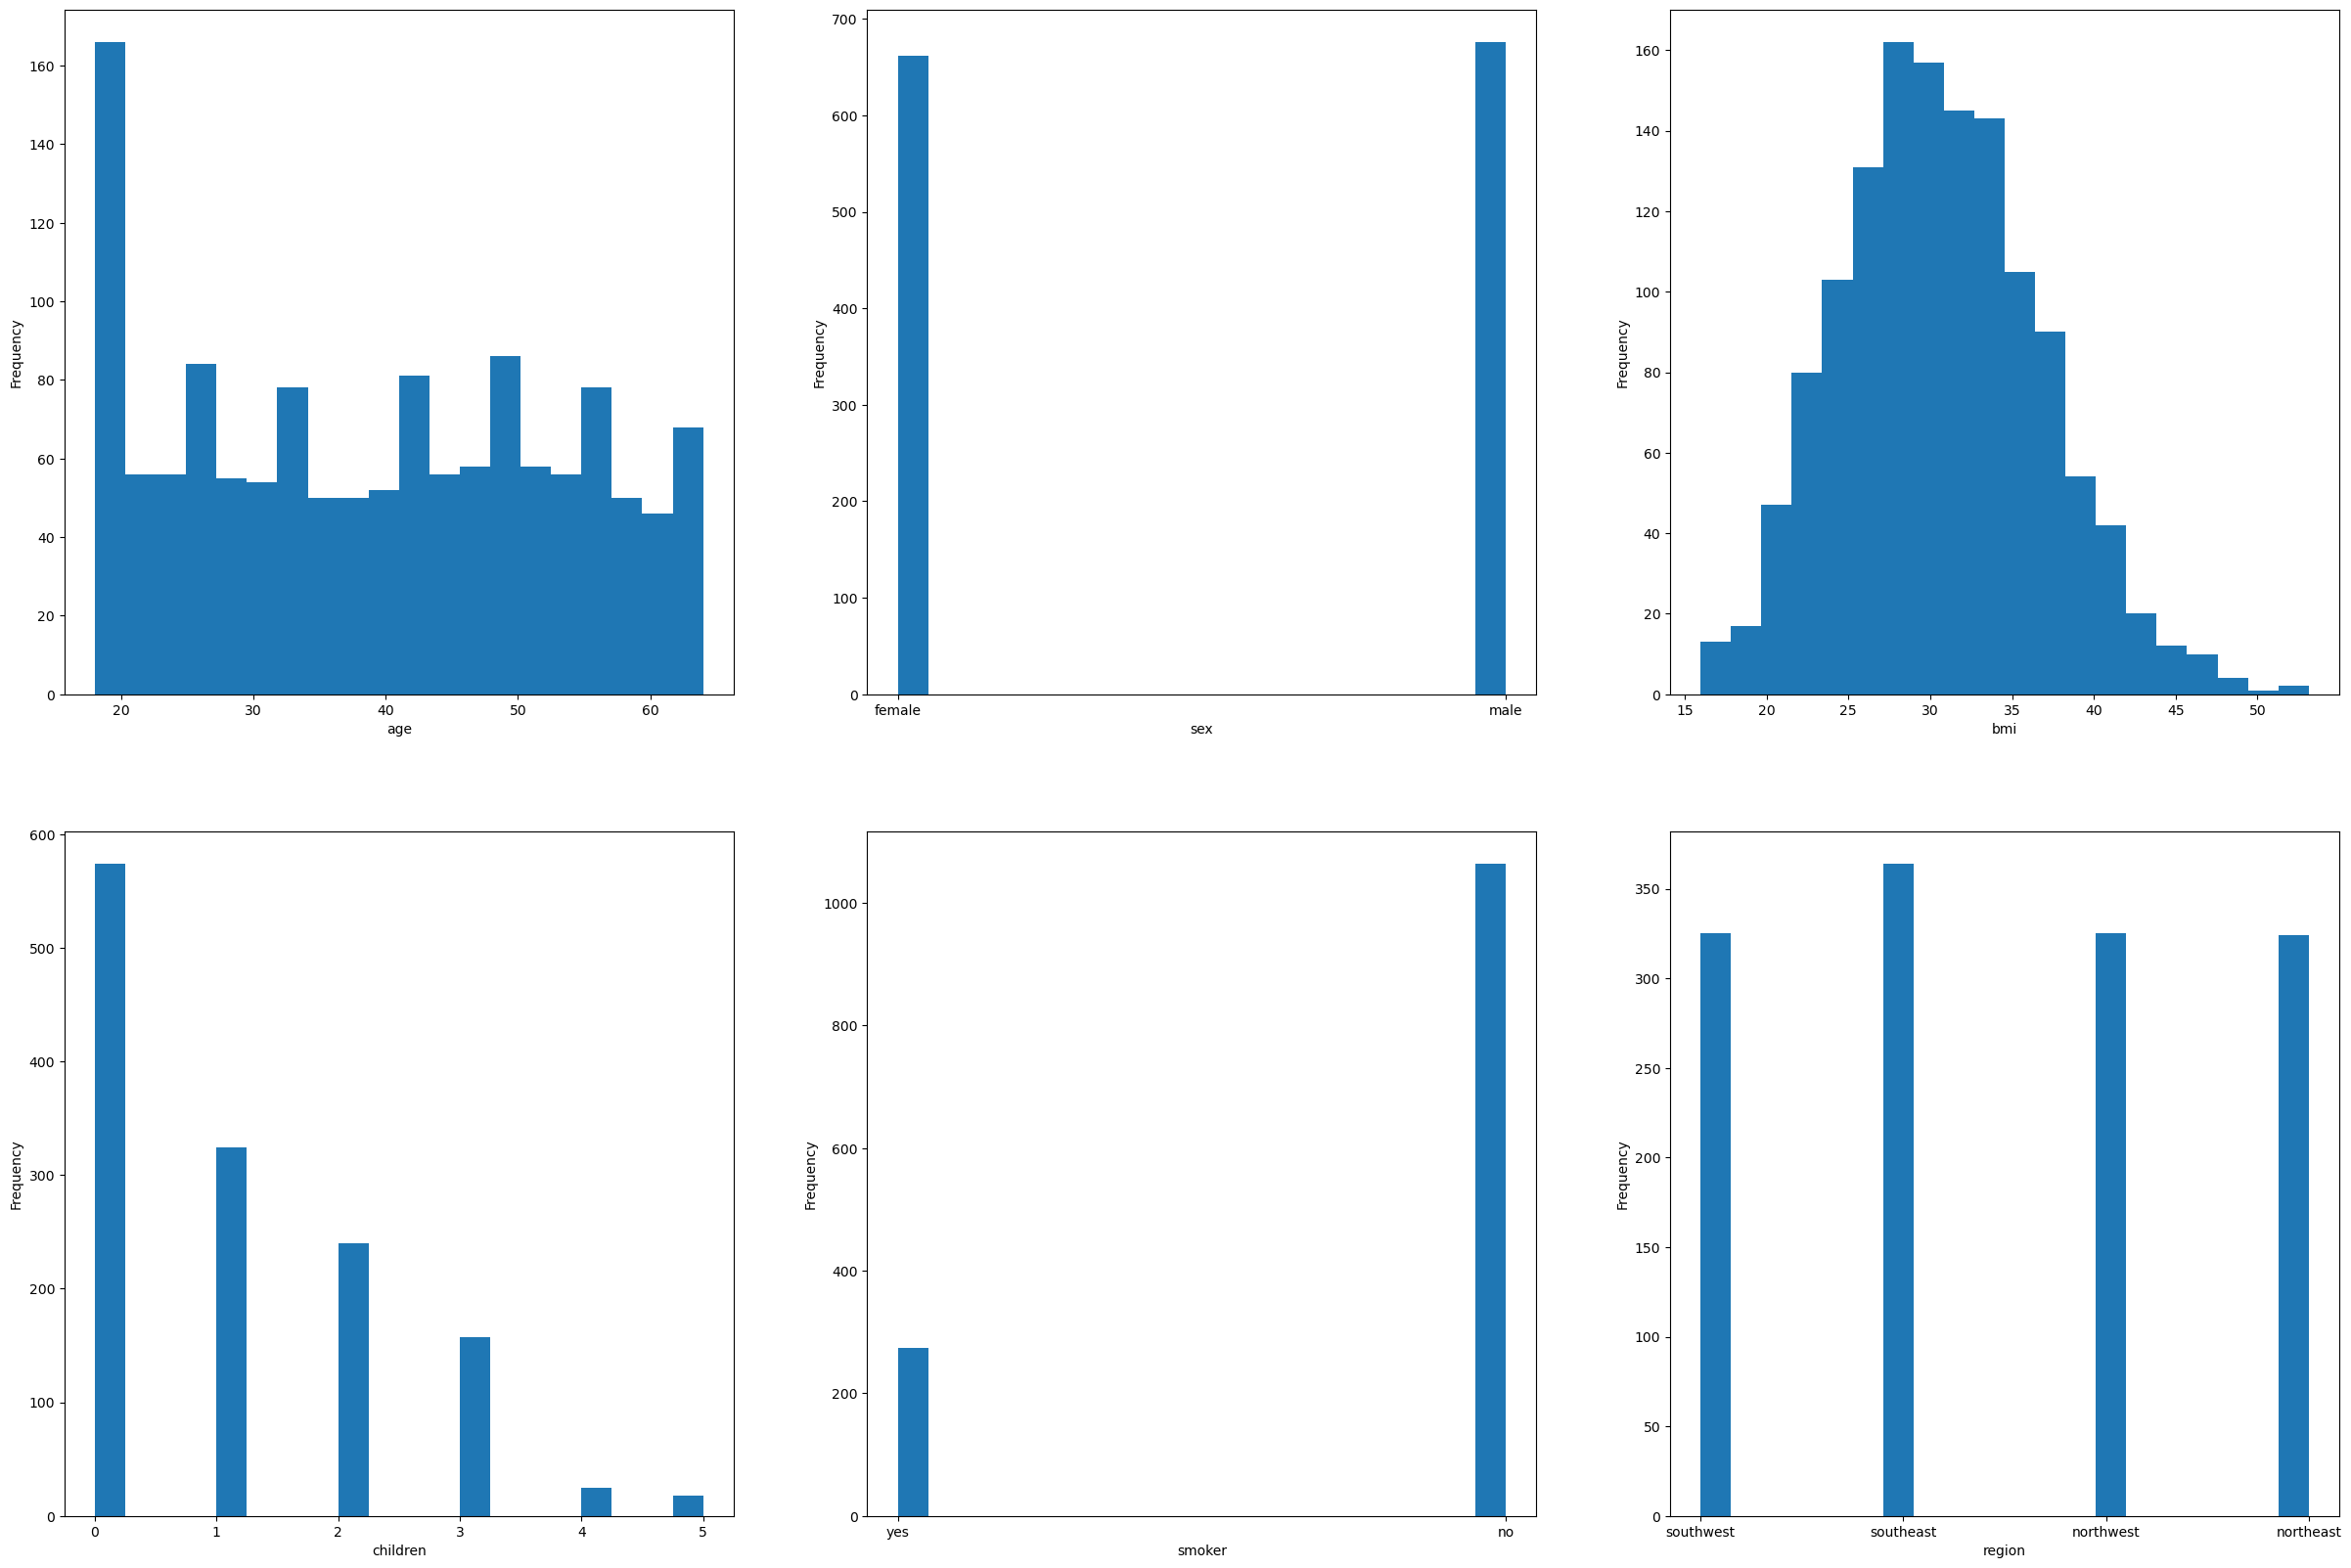

In [9]:
# 히스토그램을 통해 각 변수들의 분포 살펴보기
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

idx = 0 # 보험료를 제외한 feature들을 지정할 인덱스
for i in range(2):
    for j in range(3):
        colname = list(df.columns)[idx]
        ax[i][j].hist(df[colname], bins = 20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        
        idx+=1

#### 상관관계 파악 및 구간 만들기

In [12]:
temp = df.drop(['sex', 'smoker', 'region'], axis=1)
temp.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>,
        <Axes: xlabel='charges', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>,
        <Axes: xlabel='charges', ylabel='bmi'>],
       [<Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>,
        <Axes: xlabel='charges', ylabel='children'>],
       [<Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>,
        <Axes: xlabel='children', ylabel='charges'>,
        <Axes: xlabel='charges', ylabel='charges'>]], dtype=object)

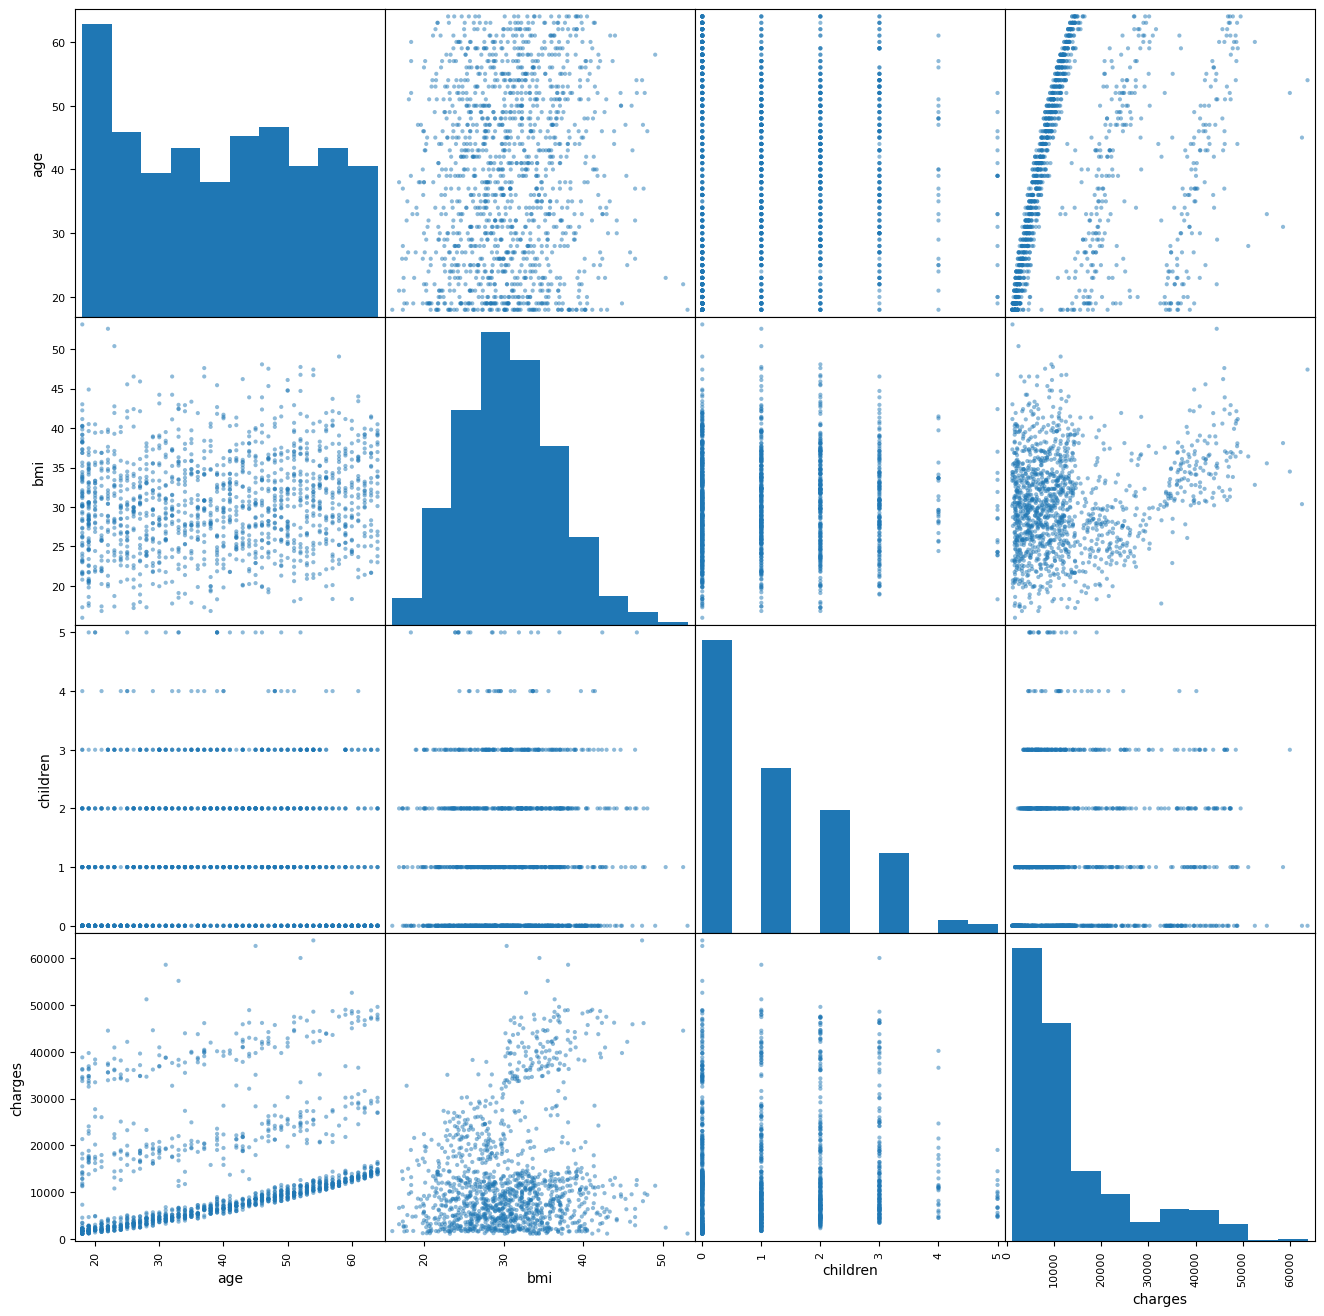

In [13]:
pd.plotting.scatter_matrix(df, figsize=(16, 16))

In [14]:
print(df['age'].min())
print(df['age'].max())

18
64


In [15]:
# 연령별 구간 설정
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, np.inf]
age_bin = pd.cut(df['age'], bins=bins, labels=[i+1 for i in range(len(bins)-1)])
# len(bins)
# age_bin
df['age_bin'] = age_bin
df.head()

,age,sex,bmi,children,smoker,region,charges,age_bin
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,3
3,33,male,22.705,0,no,northwest,21984.47061,4
4,32,male,28.880,0,no,northwest,3866.85520,4


#### 이상치 탐지

<Axes: ylabel='bmi'>

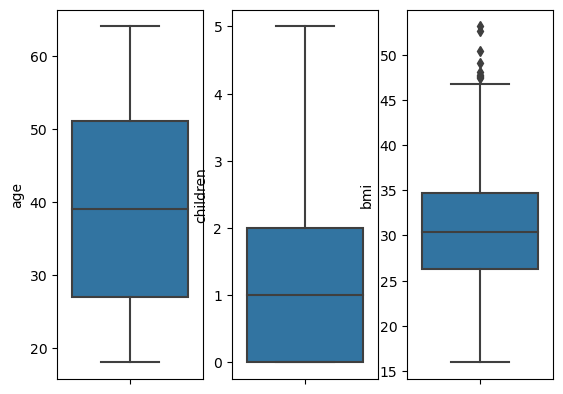

In [16]:
# 이상치 탐지를 위해 boxplot 그리기
plt.subplot(1,3,1)
sns.boxplot(data=df, y='age')
plt.subplot(1,3,2)
sns.boxplot(data=df, y='children')
plt.subplot(1,3,3)
sns.boxplot(data=df, y='bmi')

In [17]:
# IQR(Q3 - Q1)로부터 이상치 파악하기
bmi_q1 = df['bmi'].quantile(q=0.25)
bmi_q3 = df['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

# (q1 - (iqr * 1.5))와 (q3 + (iqr * 1.5))를 벗어난 값이 이상치
condi1 = (df['bmi'] < (bmi_q1 - (1.5 * iqr)))
condi2 = (df['bmi'] > (bmi_q3 + (1.5 * iqr)))
outliers = df[condi1 | condi2]
outliers['bmi'] 

116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64

In [18]:
outliers

,age,sex,bmi,children,smoker,region,charges,age_bin
116,58,male,49.06,0,no,southeast,11381.32540,9
286,46,female,48.07,2,no,northeast,9432.92530,7
401,47,male,47.52,1,no,southeast,8083.91980,7
543,54,female,47.41,0,yes,southeast,63770.42801,8
847,23,male,50.38,1,no,southeast,2438.05520,2
860,37,female,47.60,2,yes,southwest,46113.51100,5
1047,22,male,52.58,1,yes,southeast,44501.39820,2
1088,52,male,47.74,1,no,southeast,9748.91060,8
1317,18,male,53.13,0,no,southeast,1163.46270,1


In [20]:
df.drop(outliers.index, axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1329 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1329 non-null   int64   
 1   sex       1329 non-null   object  
 2   bmi       1329 non-null   float64 
 3   children  1329 non-null   int64   
 4   smoker    1329 non-null   object  
 5   region    1329 non-null   object  
 6   charges   1329 non-null   float64 
 7   age_bin   1329 non-null   category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 84.7+ KB


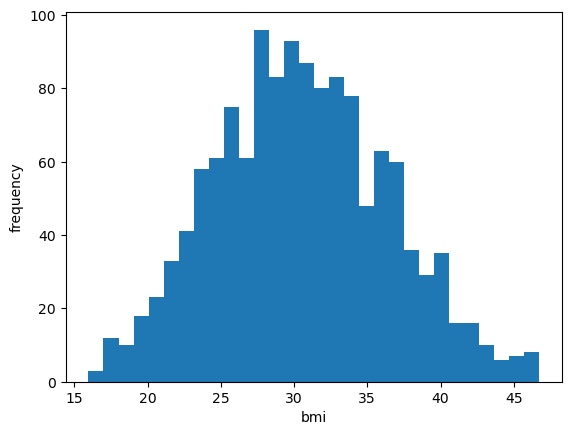

In [21]:
# bmi 분포 다시 그려보기
plt.figsize = (10, 10)
plt.hist(df['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.show()

#### Scaling, Transforming and Encoding

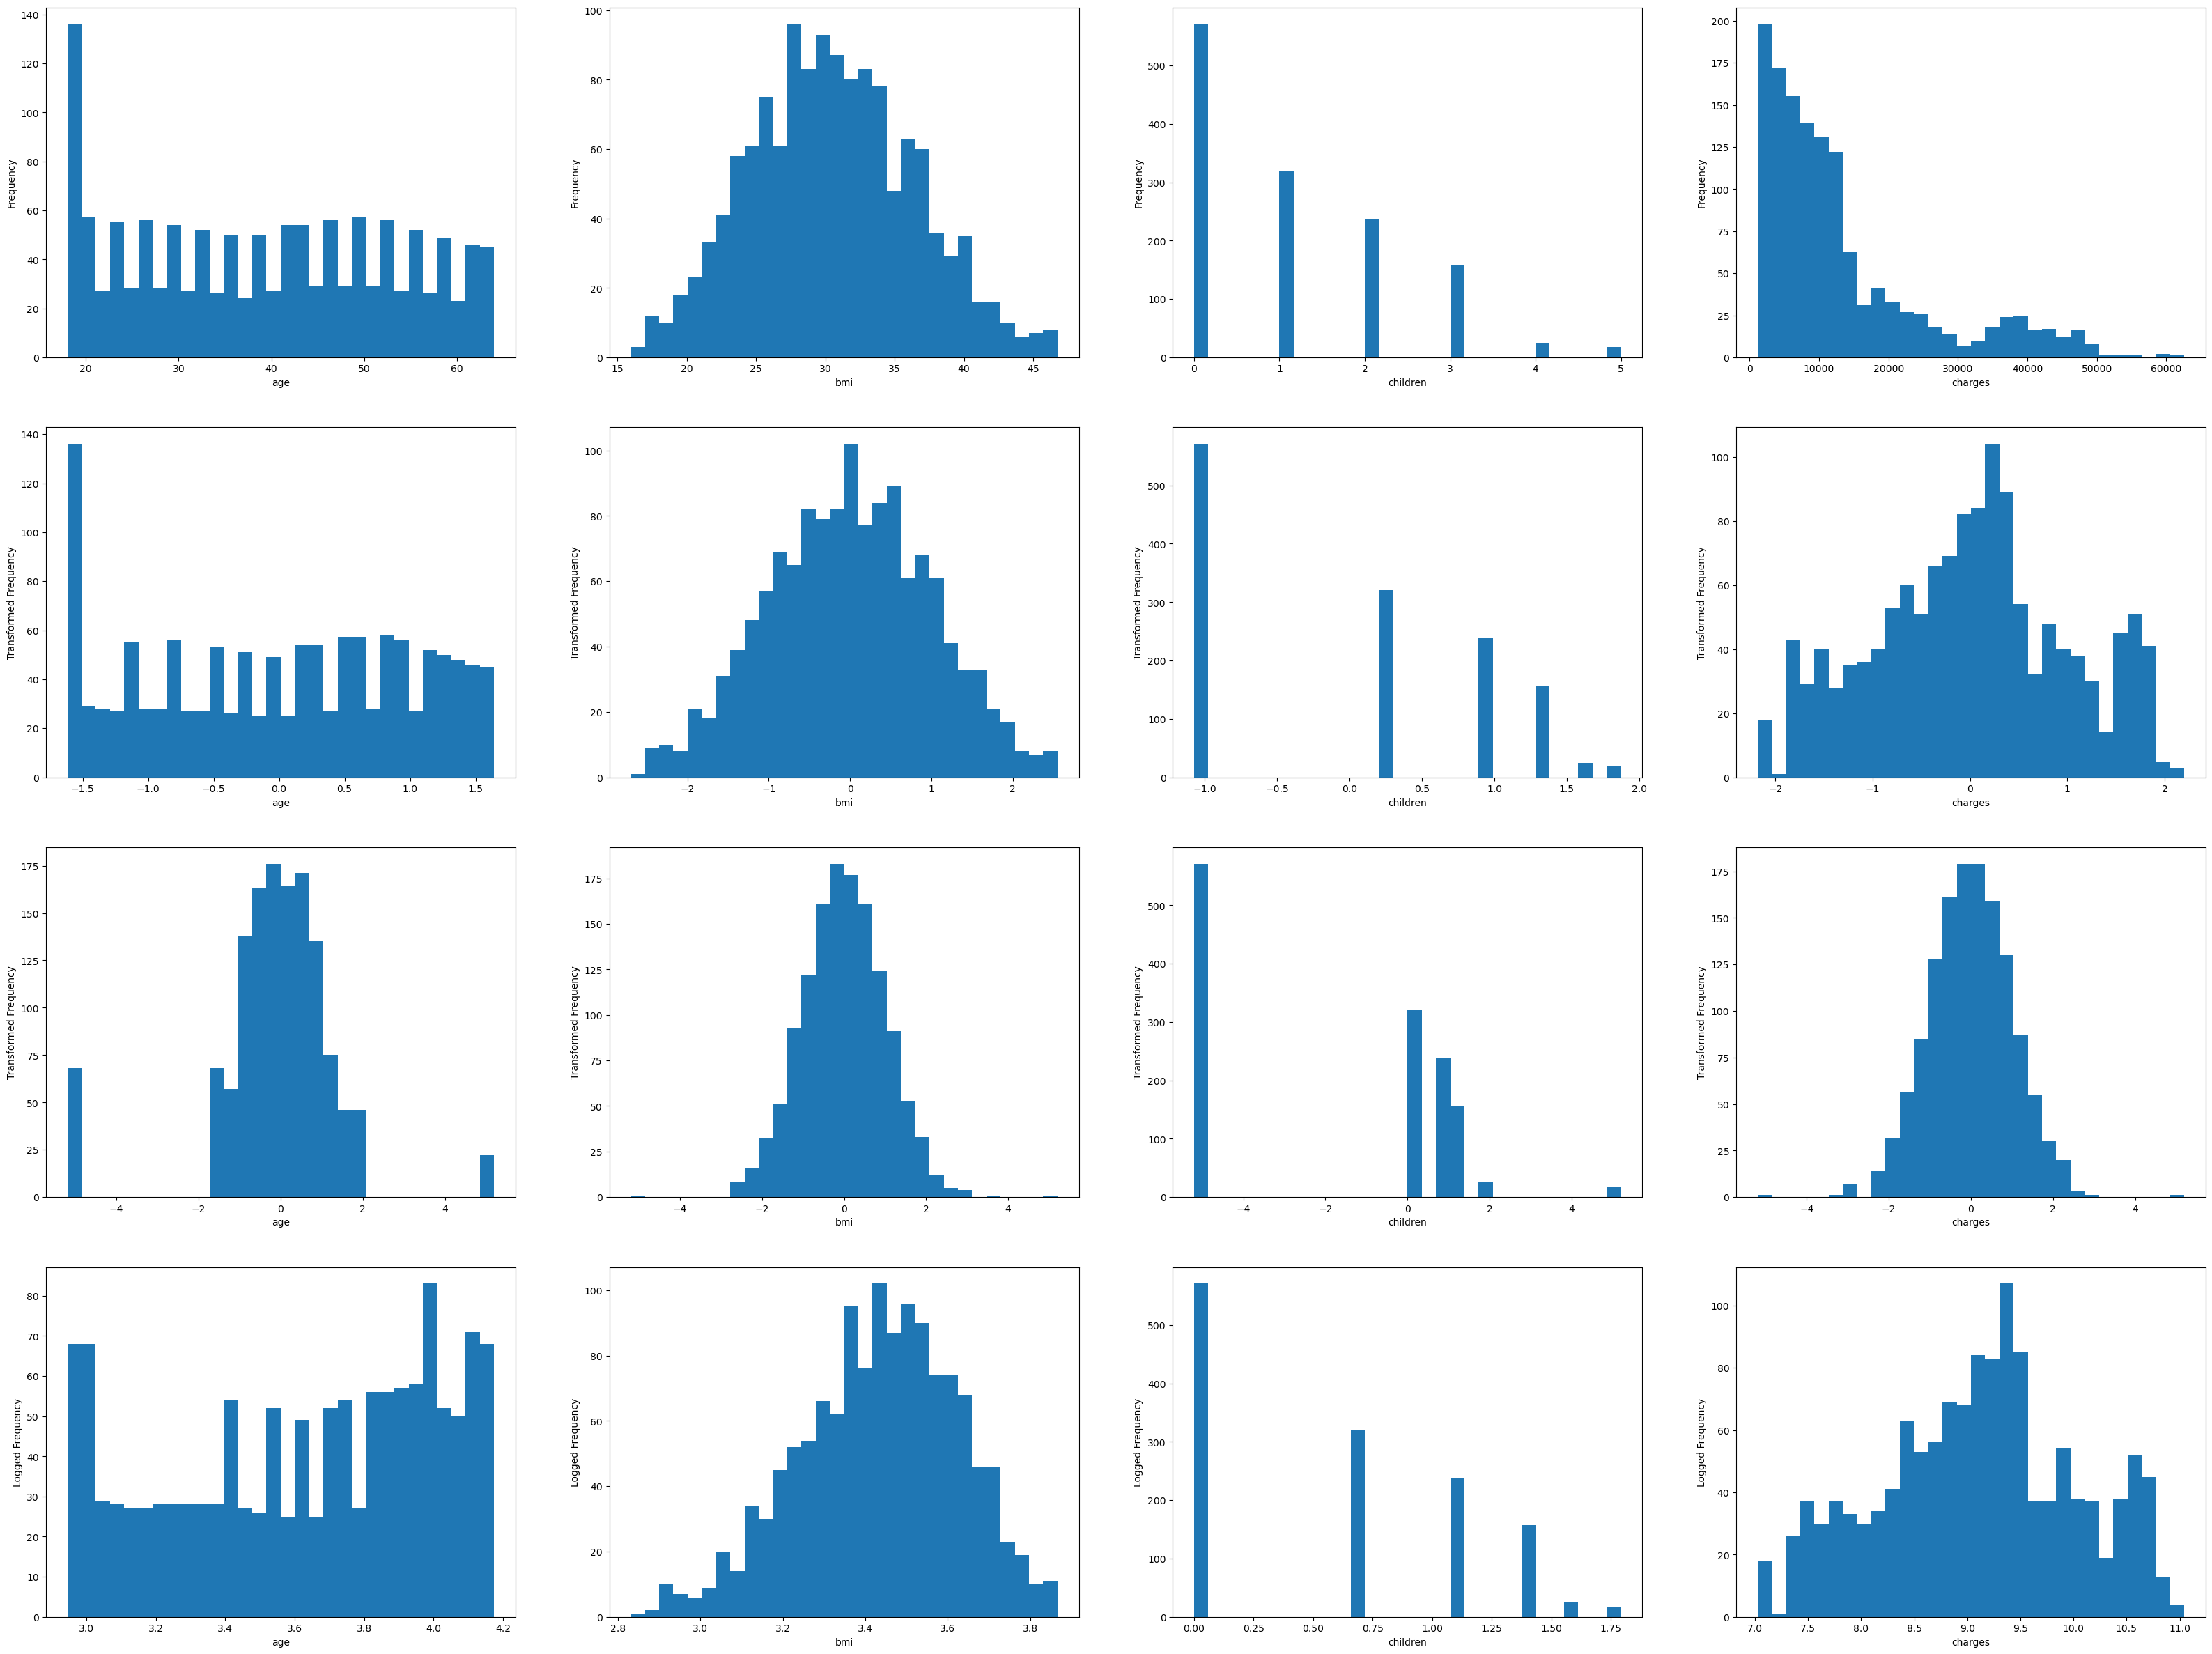

In [23]:
#숫자형 변수에 대해 Box-Cox transformation, Quantile transformation, 그리고 로그 변환
#Scaling
to_scale = ['age', 'bmi', 'children', 'charges']
df_to_scale = df[to_scale].copy()

quantile = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal') #1000개 분위를 사용해 데이터를 균등분포
power = PowerTransformer(method= 'yeo-johnson') #데이터의 특성별로 정규분포형태에 가깝도록 변환
q_scaled = quantile.fit_transform(df_to_scale)
yj = power.fit_transform(df_to_scale)

q_scaled_df = pd.DataFrame(q_scaled, columns=to_scale)
scaled_df = pd.DataFrame(yj, columns=to_scale)
logged_df = pd.DataFrame(np.log1p(df_to_scale), columns=to_scale)

fig, ax = plt.subplots(4, 4, figsize=(40, 30))

for i in range(4):
    idx = 0
    for j in range(4): #subplot들의 열
        colname = to_scale[idx]
        if i == 0 :
            ax[i][j].hist(df_to_scale[colname], bins = 30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Frequency')
        elif i == 1:
            ax[i][j].hist(scaled_df[colname], bins = 30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 2:
            ax[i][j].hist(q_scaled_df[colname], bins = 30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 3:
            ax[i][j].hist(logged_df[colname], bins = 30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Logged Frequency')
        
        idx += 1                 

In [54]:
#Standard Scaling
X = df.drop(['charges'], axis = 1)
y = df['charges'] # charges column을 종속 변수로 설정

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=X['age_bin'])

In [55]:
#Quantile Transformation
to_scale = ['age', 'bmi']

quantile = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')

for col in to_scale:
    quantile.fit(X_train[[col]])
    X_train[col] = quantile.transform(X_train[[col]]).flatten()
    X_test[col] = quantile.transform(X_test[[col]]).flatten()

In [56]:
print(X_train.isnull().sum())
X_train.head()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
age_bin     0
dtype: int64


,age,sex,bmi,children,smoker,region,age_bin
313,0.535083,male,0.856489,0,no,southeast,7
528,0.370364,male,1.322410,1,no,northeast,7
748,0.430727,female,0.876721,1,no,southwest,7
656,-0.703922,female,1.596056,1,no,southwest,3
947,-0.101941,male,0.605047,1,yes,northeast,5


In [57]:
print(X_test.isnull().sum())
X_test.head()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
age_bin     0
dtype: int64


,age,sex,bmi,children,smoker,region,age_bin
75,1.110772,male,0.576336,0,no,northwest,9
657,-0.645631,male,0.452414,2,no,northwest,3
591,0.430727,male,-1.597731,1,no,northwest,7
158,-0.482248,male,0.810129,0,yes,southeast,3
117,-0.535083,female,-0.412820,1,yes,southeast,3


In [58]:
#단위와 분포를 맞추기 위해 표준화를 진행
cols = ['age', 'bmi', 'children']
for col in cols:
    std = StandardScaler()
    std.fit(X_train[[col]])
    X_train[col] = std.transform(X_train[[col]]).flatten()
    X_test[col] = std.transform(X_test[[col]]).flatten()
    
X_train.describe()

,age,bmi,children
count,9.960000e+02,9.960000e+02,9.960000e+02
mean,-5.350472e-18,2.318538e-17,-5.707171e-17
std,1.000502e+00,1.000502e+00,1.000502e+00
min,-3.215713e+00,-5.624930e+00,-9.277802e-01
25%,-3.664094e-01,-7.133659e-01,-9.277802e-01
50%,7.635845e-02,-2.863350e-02,-9.603485e-02
75%,4.889697e-01,6.851943e-01,7.357105e-01
max,3.375219e+00,5.620169e+00,3.230946e+00


In [62]:
# one-hot encoding을 사용해 성별을 정수로 변환
encoder = OneHotEncoder()
sex_train = X_train[['sex']]
sex_test = X_test[['sex']]

encoder.fit(sex_train) 
sex_train_onehot = encoder.transform(sex_train).toarray()
sex_test_onehot = encoder.fit_transform(sex_test).toarray()

# 여성을 0, 남성을 1로 두고, 정수형으로 변환
X_train['sex'] = sex_train_onehot[:, 1].astype(np.uint8) 
X_test['sex'] = sex_test_onehot[:, 1].astype(np.uint8)

X_train.head()

,age,sex,bmi,children,smoker,region,age_bin
313,0.418902,1,0.923824,-0.927780,no,southeast,7
528,0.314499,1,1.427669,-0.096035,no,northeast,7
748,0.352759,0,0.945703,-0.096035,no,southwest,7
656,-0.366409,0,1.723590,-0.096035,no,southwest,3
947,0.015141,1,0.651915,-0.096035,yes,northeast,5


In [63]:
# one-hot encoding으로 흡연자 여부 변환
onehot_smoker = OneHotEncoder()
smoker_train = X_train[['smoker']]
smoker_test = X_test[['smoker']]

onehot_smoker.fit(smoker_train) # sklearn의 OneHotEncoder는 2차원 배열(또는 데이터프레임)이 input으로 들어가야 합니다.
smoker_train_onehot = onehot_smoker.transform(smoker_train).toarray()
smoker_test_onehot = onehot_smoker.transform(smoker_test).toarray()

X_train['smoker'] = smoker_train_onehot[:, 1].astype(np.uint8) # 비흡연자를 0, 흡연자를 1로 두겠습니다.
X_test['smoker'] = smoker_test_onehot[:, 1].astype(np.uint8)

X_train.head()

,age,sex,bmi,children,smoker,region,age_bin
313,0.418902,1,0.923824,-0.927780,0,southeast,7
528,0.314499,1,1.427669,-0.096035,0,northeast,7
748,0.352759,0,0.945703,-0.096035,0,southwest,7
656,-0.366409,0,1.723590,-0.096035,0,southwest,3
947,0.015141,1,0.651915,-0.096035,1,northeast,5


In [64]:
# 거주지역을 LabelEncoder로 숫자형으로 우선 변환
label_region = LabelEncoder()
label_region.fit(X_train['region']) # LabelEncoder는 1차원 배열이 input으로 들어가야 합니다.

X_train['region'] = label_region.transform(X_train['region'])
X_test['region'] = label_region.transform(X_test['region'])

X_train.head()

,age,sex,bmi,children,smoker,region,age_bin
313,0.418902,1,0.923824,-0.927780,0,2,7
528,0.314499,1,1.427669,-0.096035,0,0,7
748,0.352759,0,0.945703,-0.096035,0,3,7
656,-0.366409,0,1.723590,-0.096035,0,3,3
947,0.015141,1,0.651915,-0.096035,1,0,5


In [65]:
# one-hot encoding으로 거주지역 바꾸기
onehot_region = OneHotEncoder()
region_train = X_train[['region']]
region_test = X_test[['region']]

onehot_region.fit(region_train) 
region_train_onehot = onehot_region.transform(region_train).toarray()
region_test_onehot = onehot_region.transform(region_test).toarray()

X_train['region_1'] = region_train_onehot[:, 1].astype(np.uint8)
X_train['region_2'] = region_train_onehot[:, 2].astype(np.uint8)
X_train['region_3'] = region_train_onehot[:, 3].astype(np.uint8)

X_test['region_1'] = region_test_onehot[:, 1].astype(np.uint8)
X_test['region_2'] = region_test_onehot[:, 2].astype(np.uint8)
X_test['region_3'] = region_test_onehot[:, 3].astype(np.uint8)

X_train.drop(['region', 'age_bin'], axis=1, inplace=True)
X_test.drop(['region', 'age_bin'], axis=1, inplace=True)

In [66]:
X_train.head()

,age,sex,bmi,children,smoker,region_1,region_2,region_3
313,0.418902,1,0.923824,-0.927780,0,0,1,0
528,0.314499,1,1.427669,-0.096035,0,0,0,0
748,0.352759,0,0.945703,-0.096035,0,0,0,1
656,-0.366409,0,1.723590,-0.096035,0,0,0,1
947,0.015141,1,0.651915,-0.096035,1,0,0,0


In [67]:
X_test.head()

,age,sex,bmi,children,smoker,region_1,region_2,region_3
75,0.783787,1,0.620867,-0.927780,0,1,0,0
657,-0.329463,1,0.486859,0.735710,0,1,0,0
591,0.352759,1,-1.730162,-0.096035,0,1,0,0
158,-0.225907,1,0.873691,-0.927780,1,0,1,0
117,-0.259395,0,-0.448803,-0.096035,1,0,1,0


#### Model Selection

In [68]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(996, 8) (996,)
(333, 8) (333,)


In [69]:
# default 모델을 설정한 뒤, cross-validation을 통해 성능을 평가
lr = LinearRegression()
enet = ElasticNet(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

models = [lr, enet, dt, rf, ada, gbr, xgb, lgbm]

In [70]:
# 평가지표 RMSE
for model in models:
    name = model.__class__.__name__
    scores = cross_val_score(model, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = (-1) * np.mean(scores) # negative mean squared error로 설정했으므로 -1을 곱해 부호를 맞춰줍니다.
    print('Model %s - RMSE: %.4f' % (name, np.sqrt(mse)))

Model LinearRegression - RMSE: 6415.7267
Model ElasticNet - RMSE: 9609.0652
Model DecisionTreeRegressor - RMSE: 6377.2354
Model RandomForestRegressor - RMSE: 4917.3047
Model AdaBoostRegressor - RMSE: 5211.7117
Model GradientBoostingRegressor - RMSE: 4695.0703
Model XGBRegressor - RMSE: 5302.2534


/Users/lenovo/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/lenovo/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/lenovo/anaconda3/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/lenovo/anaconda3/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/lenovo/anaconda3/lib/python3.11/site-

Model LGBMRegressor - RMSE: 4827.5845


#### Hyperparameter Tuning

In [72]:
# Gradient Boosting
gbr_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 80, 100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'random_state': [42]
}

gbr_search = GridSearchCV(gbr, param_grid=gbr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gbr_search.fit(X_train, y_train)
best_mse = (-1) * gbr_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), gbr_search.best_params_))

Best score: 4578.9503, Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


In [74]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'random_state': [42]
}

rf_search = GridSearchCV(gbr, param_grid=rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_search.fit(X_train, y_train)
best_mse = (-1) * rf_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), rf_search.best_params_))

Best score: 4634.9909, Best params: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [75]:
# LGBM
lgbm_params = {
    'num_leaves': [25, 31, 35],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [3, 7, 11],
    'random_state': [42]
}

lgbm_search = GridSearchCV(lgbm, param_grid=lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_search.fit(X_train, y_train)
best_mse = (-1) * lgbm_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), lgbm_search.best_params_))

Best score: 4564.7908, Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 25, 'random_state': 42}


#### Test 및 결과 확인

In [76]:
gbr_final = GradientBoostingRegressor(**gbr_search.best_params_)

gbr_final.fit(X_train, y_train)
y_pred_gbr = gbr_final.predict(X_test)

name = gbr_final.__class__.__name__

# Test RMSE
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_gbr)))

RMSE of GradientBoostingRegressor: 4245.3937


In [77]:
rf_final = RandomForestRegressor(**rf_search.best_params_)

rf_final.fit(X_train, y_train)
y_pred_rf = rf_final.predict(X_test)

name = rf_final.__class__.__name__

# Test RMSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_rf)))

RMSE of RandomForestRegressor: 4261.9023


In [78]:
lgbm_final = LGBMRegressor(**lgbm_search.best_params_)

lgbm_final.fit(X_train, y_train)
y_pred_lgbm = lgbm_final.predict(X_test)

name = lgbm_final.__class__.__name__

# Test RMSE
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
print('RMSE of %s: %.4f' % (name, np.sqrt(mse_lgbm)))

RMSE of LGBMRegressor: 4200.8481
